# Image Classification and Segmentation

## Introduction

Image segmentation and classification are very important topics in GIS and remote sensing applications. Both approaches are to extracting features from imagery based on objects. Segmentation groups pixels in close proximity and having similar spectral characteristics into a segment, which doesn't need any training data and is considered as **unsupervised learning**. In contrast, image classification is a type of **supervised learning** which classifies each pixel to a class in the training data. In this guide, we are going to demonstrate both techniques using ArcGIS API for Python.

In [1]:
import arcgis
from arcgis import GIS
from arcgis.raster.analytics import *
from arcgis.features import FeatureSet, FeatureCollection

In [2]:
gis = GIS(profile="your_enterprise_profile")

## Classification

In this example, we are going to perfrom a land cover classification using a Landsat image in Iowa and hand labelled training data. In the training data, there are four classes in total: Developed Area, Forest, Planted/Cultivated, and Water.

First, let's draw the training data on a map and visualize it.

<Item title:"training_samples" type:Feature Layer Collection owner:api_data_owner>
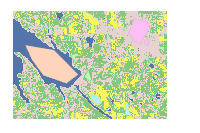

In [3]:
items1 = gis.content.search("training_samples", item_type="Feature Layer")
items1[0]


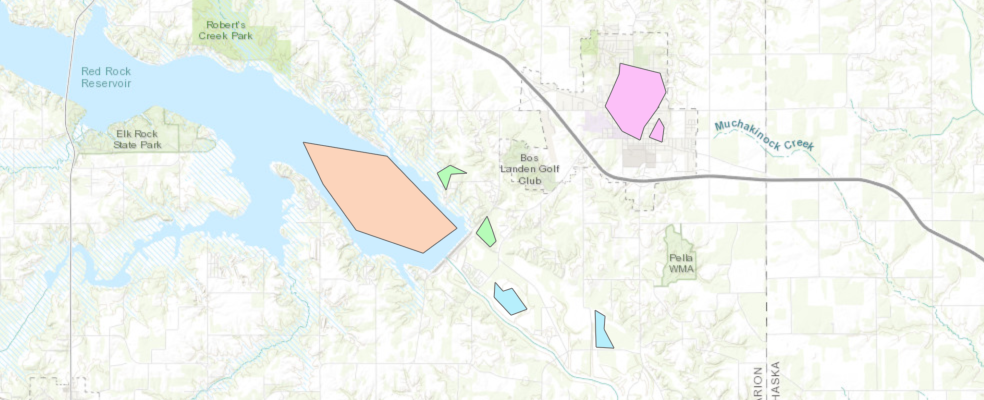

In [28]:
map1 = gis.map('Iowa')
map1

In [4]:
defined_extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                  'xmin': -10357358.3716515,
                  'ymin': 5063187.75726388,
                  'xmax': -10340267.8481094,
                  'ymax': 5075204.7581259}

In [14]:
map1.extent = defined_extent
map1.add_layer(items1[0])

In [15]:
map1.legend = True

We need to convert the training sample feature class into JSON format, which is the format the image classification requires.

In [5]:
query_result = items1[0].layers[0].query()
training_sample_json = query_result.to_json

Now let's search for Landsat data that will be used for image classification.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
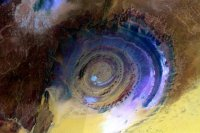

In [8]:
items2 = gis.content.search("title: multispectral landsat", item_type="Imagery Layer", outside_org=True) 
items2[0]

In [9]:
landsat_layer = items2[0].layers[0]

Set the analysis extent to a small region in Iowa so we don't process all landsat images.

In [10]:
arcgis.env.verbose = True
arcgis.env.analysis_extent = defined_extent

We can retrieve a landsat scene by `OBJECTID`.

In [11]:
filtered_layer = landsat_layer.filter_by('OBJECTID=3134102')

With the Landsat layer and the training samples, we are now ready to train a support vector machine (SVM) model.

In [21]:
classifier_definition = train_classifier(input_raster=filtered_layer, 
                                         input_training_sample_json=training_sample_json, 
                                         classifier_parameters={"method":"svm", 
                                                                "params":{"maxSampleClass":500}},
                                         gis=gis)

Submitted.
Executing...
TrainClassifier GP Job: j5346913284a9402c9cf5f4e5268dc004 finished successfully.


If we print out `classifier_definition`, we can see that it contains information such as number of classes and coefficients that define the SVM model.

In [31]:
classifier_definition["Definitions"][0]["Classes"]

[{'ClassValue': 10,
  'ClassName': 'Water',
  'Red': 84,
  'Green': 117,
  'Blue': 168},
 {'ClassValue': 20,
  'ClassName': 'Developed',
  'Red': 232,
  'Green': 209,
  'Blue': 209},
 {'ClassValue': 40,
  'ClassName': 'Forest',
  'Red': 133,
  'Green': 199,
  'Blue': 126},
 {'ClassValue': 80,
  'ClassName': 'Planted / Cultivated',
  'Red': 251,
  'Green': 246,
  'Blue': 93}]

Now we have the model, we are ready to apply the model to a landsat image to make prediction.

In [16]:
from arcgis.raster.analytics import classify

classified_output = classify(input_raster=filtered_layer,
                             input_classifier_definition=classifier_definition)
classified_output

Submitted.
Executing...
Start Time: Wednesday, October 23, 2019 10:19:59 AM
Running script Classify...
Image service {'name': 'Classify_X8UHPJ', 'serviceUrl': 'https://datascienceqa.esri.com/server/rest/services/Hosted/Classify_X8UHPJ/ImageServer'} already existed.
Classifying...
Finished
Updating service with data store URI.
Getting image service info...
Updating service: https://datascienceqa.esri.com/server/admin/services/Hosted/Classify_X8UHPJ.ImageServer/edit
Update item service: https://datascienceqa.esri.com/server/admin/services/Hosted/Classify_X8UHPJ.ImageServer successfully.
Portal item refreshed.
Completed script Classify...
Succeeded at Wednesday, October 23, 2019 10:20:22 AM (Elapsed Time: 23.15 seconds)
Classify GP Job: j2900fe86b1b74244b00188cc8f4a9974 finished successfully.


<Item title:"Classify_X8UHPJ" type:Imagery Layer owner:portaladmin>


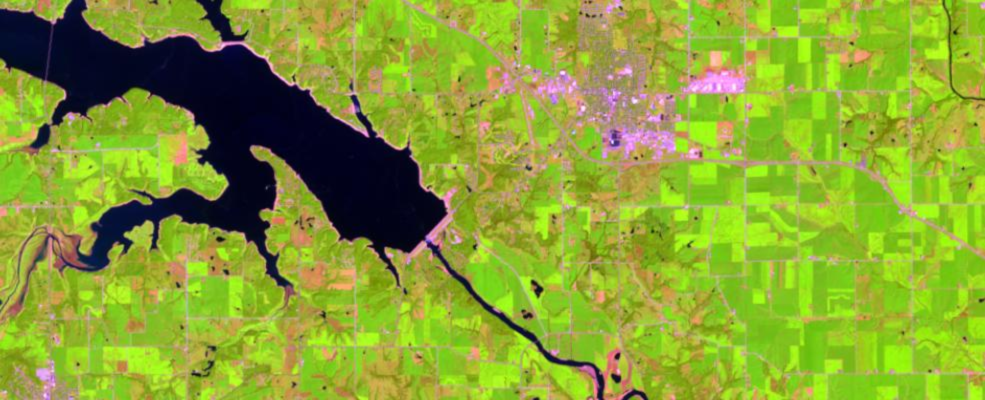

In [17]:
map2 = gis.map('Iowa')
map2

In [16]:
map2.extent = defined_extent
map2.add_layer(filtered_layer)

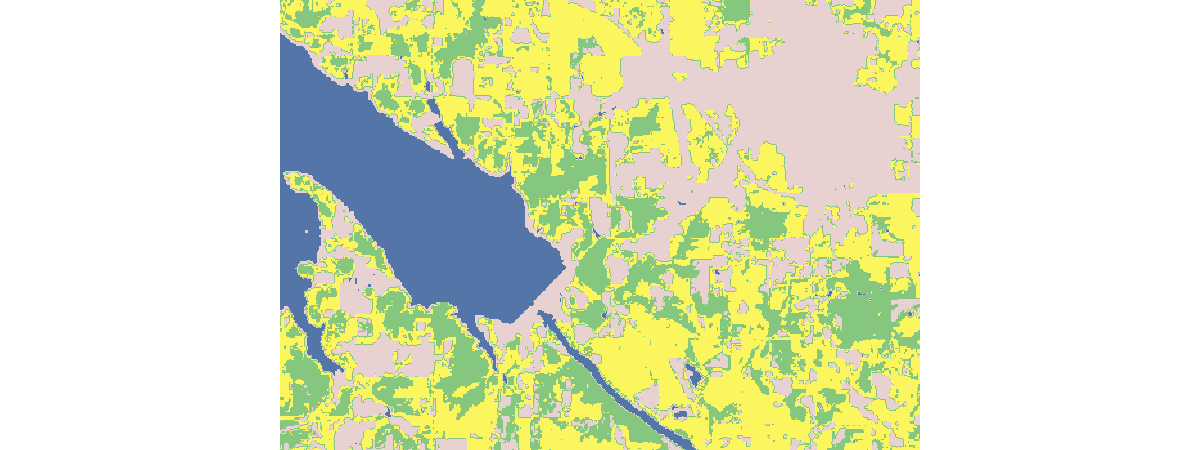

In [36]:
classified_output.layers[0]

We can see that our model is making reasonable prediction results by comparing the prediction with the Landsat image. For example, water has been clearly identified.

## Segmentation

The goal of image segmentation is to identify segments in your imagery by grouping adjacent pixels together that have similar spectral and spatial characteristics. `arcgis.raster.analytics.segment` uses an algorithm called [Mean Shift](https://pro.arcgis.com/en/pro-app/help/data/imagery/segment-mean-shift-function.htm) which uses a moving window that calculates an average pixel value to determine which pixels should be included in each segment. As the window moves over the image, it iteratively recomputes the value to make sure that each segment is suitable. The result is a grouping of image pixels into a segment characterized by an average color.

In this example, we are going to use image segmentation to extract center-pivot in a chosen region in Saudi Arabia. First, let's search for a 8-bit landsat layer we've published beforehand. *Please note that our image segmentation requires the input raster layer to be 8-bit.*

In [30]:
landsat_pivot_items = gis.content.search("title: landsat_pviot_345_8bit", item_type="Imagery Layer")
landsat_pivot_items[0]

<Item title:"landsat_pviot_345_8bit" type:Imagery Layer owner:api_data_owner>

In [31]:
landsat_pivot_layer = landsat_pivot_items[0].layers[0]


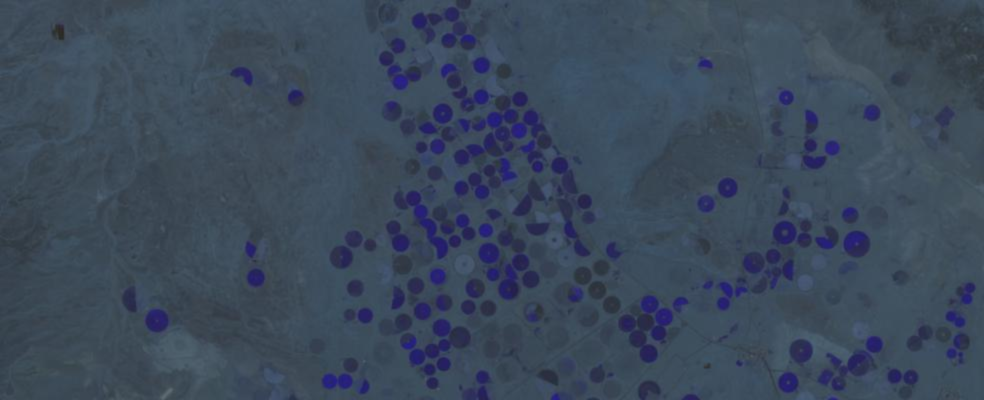

In [44]:
map3 = gis.map('Saudi Arabia')
map3

In [43]:
map2.add_layer(landsat_pivot_layer);

The characteristics of the image segments depend on three parameters: spectral detail, spatial detail, and minimum segment size. These parameters determine whether a pixel should be part of a segment or not. You can vary the amount of detail that characterizes a feature of interest. For example, if you are more interested in impervious features than in individual buildings, adjust the spatial detail parameter to a small number; a lower number results in more smoothing and less detail.

- The segment function provides multi-band support. You can define which 3 bands are used in segmentation. Default is [0,1,2]. 
- `spectral_detail` parameter is used to set the level of importance given to the spectral differences of features in your imagery. Default is 15.5.
- `spatial_detail`, on the other hand, sets the level of importance given to the proximity between features in your imagery. Default is 15.

In [53]:
from arcgis.raster.analytics import segment

seg_output = segment(input_raster=landsat_pivot_layer) # it uses band [0, 1, 2] by default
seg_output

<Item title:"Segment_V2BP9O" type:Imagery Layer owner:portaladmin>


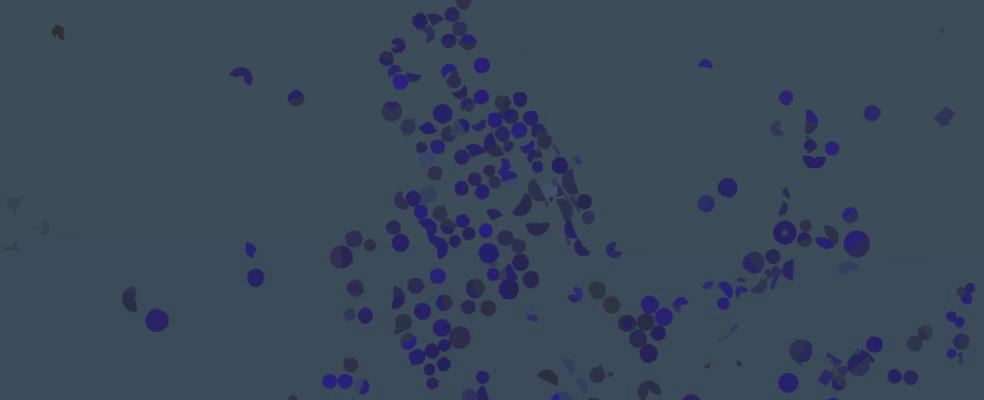

In [62]:
map3 = gis.map('Saudi Arabia')
map3

In [61]:
map3.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                                         'type': 'extent',
                                         'xmax': 4735079.27946308,
                                         'xmin': 4720420.87480519,
                                         'ymax': 3226614.75178954,
                                         'ymin': 3214862.51053094}
map3.add_layer(seg_output)

Now we can see most of the center pivots have been correctly extracted. Notice that by default the function uses band [0, 1, 2] for segmentation and renders the result using the same colormap.